### Section C - (B) - Z0 Boson Decay Flavour Tagging - Improve the Classifier

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Normalization

import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import ast
import random
from scipy.stats import zscore
import importlib

import uproot
from IPython.display import display
import time

In [101]:
import utils.data_create
import utils.model

importlib.reload(utils.data_create)
importlib.reload(utils.model)

from utils.data_create import *
from utils.model import *

In [5]:
# Set random seeds for reproducibility
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

event_ratio = 0.3

### Data Load and Prepare

In [6]:
ft = time.time()
df = load_data(event_ratio)
lt = time.time()

print('time-taken-load-data: ', (lt - ft)/60, ' mins')

display(df.head(5))

print()
print('#Events: ', len(df))

time-taken-load-data:  0.4707902113596598  mins


,Thrust_x,Thrust_y,Thrust_z,nParticle,nVertex,Vertex_chi2,Vertex_ntracks,Vertex_chi2_mean,Vertex_chi2_std,Particle_p,Particle_pt,label,Particle_p_mean,Particle_pt_mean
0,-0.433526,-0.406958,-0.804015,64,6,"[1.2095627784729004, 0.7420068979263306, 1.089...",0.845224,3.833333,0.401963,"[8.975488662719727, 4.306334972381592, 4.41255...","[5.82358980178833, 3.549351215362549, 3.187218...",0,1.360159,0.938508
1,-0.910737,0.281932,0.301782,63,2,"[0.8263425230979919, 0.5531902313232422]",0.689766,12.000000,0.136576,"[8.612483978271484, 6.647984981536865, 5.34825...","[8.461196899414062, 6.549235820770264, 5.18732...",2,1.391773,1.265439
2,-0.242391,0.105400,0.964436,36,1,[1.0121797323226929],1.012180,23.000000,0.000000,"[13.643109321594238, 21.797975540161133, 5.661...","[3.448850393295288, 3.3437514305114746, 1.8353...",3,2.501927,0.747944
3,0.455778,-0.013473,0.889992,36,3,"[0.8001490235328674, 0.5654799342155457, 6.808...",2.724836,5.000000,2.889443,"[5.716642379760742, 8.712882041931152, 5.79783...","[3.2425029277801514, 3.107431173324585, 2.9376...",0,2.023315,0.954926
4,0.348787,0.447944,-0.823222,23,1,[1.607759952545166],1.607760,10.000000,0.000000,"[18.91507911682129, 12.161049842834473, 11.022...","[11.018609046936035, 6.781800746917725, 6.6958...",3,3.939587,2.283327



#Events:  243023


At each event an arbitary number of particles can decay (>1) --> taking average of that scaler momentum 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243023 entries, 0 to 243022
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Thrust_x          243023 non-null  float64
 1   Thrust_y          243023 non-null  float64
 2   Thrust_z          243023 non-null  float64
 3   nParticle         243023 non-null  int32  
 4   nVertex           243023 non-null  int32  
 5   Vertex_chi2       243023 non-null  object 
 6   Vertex_ntracks    243023 non-null  float64
 7   Vertex_chi2_mean  243023 non-null  float64
 8   Vertex_chi2_std   243023 non-null  float64
 9   Particle_p        243023 non-null  object 
 10  Particle_pt       243023 non-null  object 
 11  label             243023 non-null  int64  
 12  Particle_p_mean   243023 non-null  float64
 13  Particle_pt_mean  243023 non-null  float64
dtypes: float64(8), int32(2), int64(1), object(3)
memory usage: 24.1+ MB


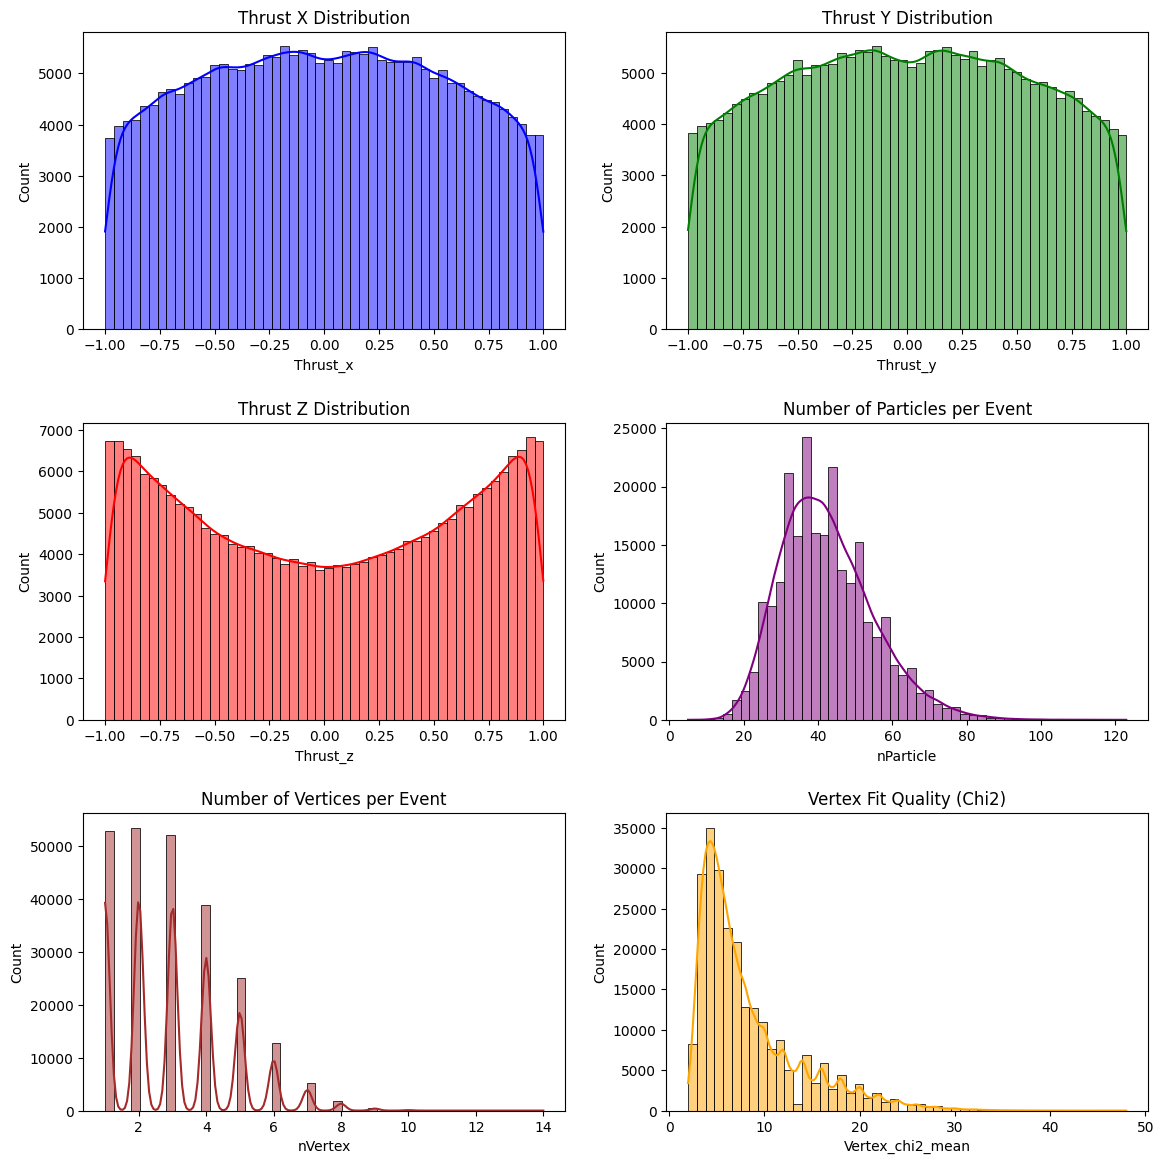

C:\Users\Alik\AppData\Local\Temp\ipykernel_28280\287894437.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], ax=axes[2], palette="Set2")


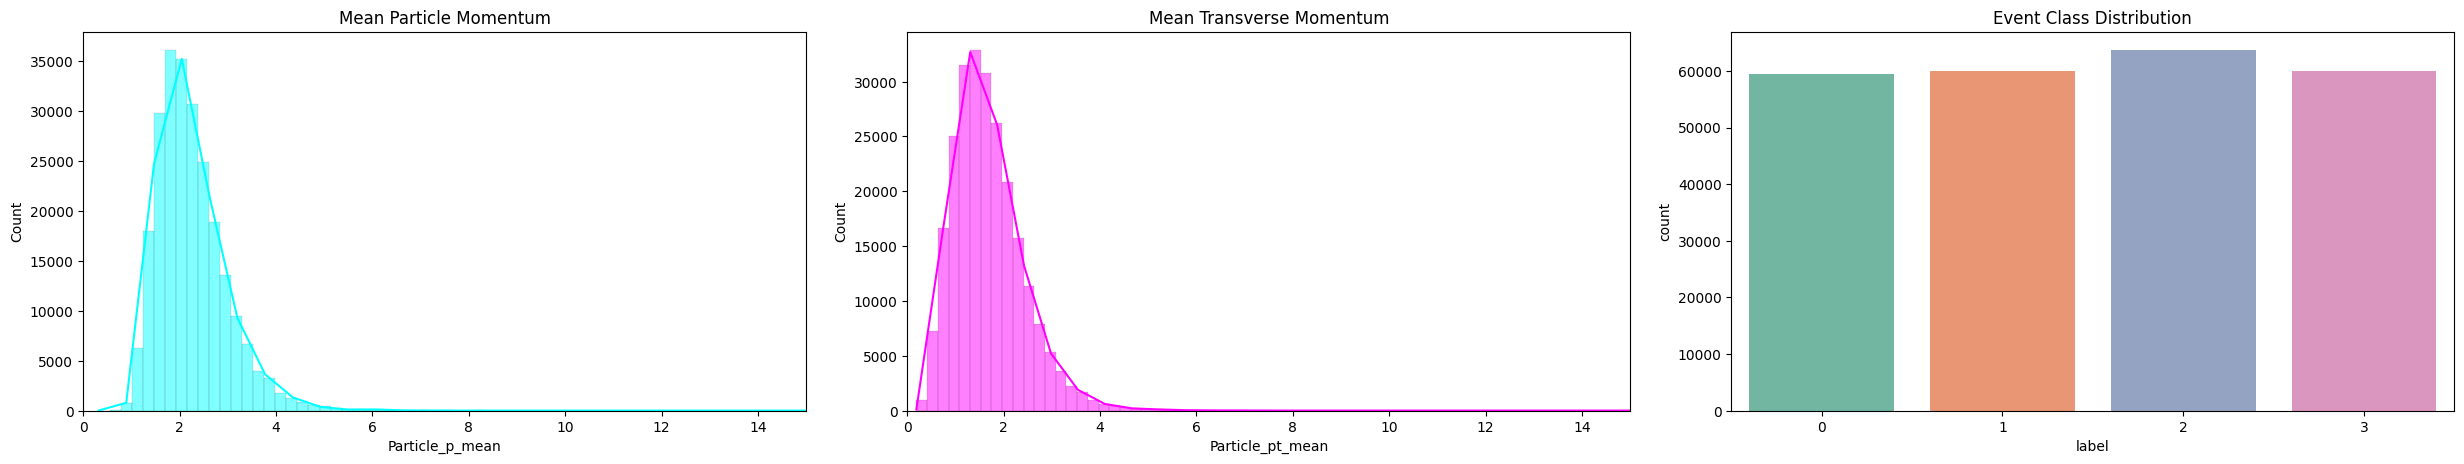

In [8]:
def visualize_data(df):
    """Generates various plots to understand the dataset."""
    
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    
    # Thrust Distributions
    sns.histplot(df['Thrust_x'], kde=True, ax=axes[0, 0], bins=50, color='blue')
    sns.histplot(df['Thrust_y'], kde=True, ax=axes[0, 1], bins=50, color='green')
    sns.histplot(df['Thrust_z'], kde=True, ax=axes[1, 0], bins=50, color='red')
    axes[0, 0].set_title('Thrust X Distribution')
    axes[0, 1].set_title('Thrust Y Distribution')
    axes[1, 0].set_title('Thrust Z Distribution')

    # Particle and Vertex Counts
    sns.histplot(df['nParticle'], bins=50, kde=True, ax=axes[1, 1], color='purple')
    axes[1, 1].set_title('Number of Particles per Event')

    sns.histplot(df['nVertex'], bins=50, kde=True, ax=axes[2, 0], color='brown')
    axes[2, 0].set_title('Number of Vertices per Event')

    # Vertex Fit Quality (Chi2)
    sns.histplot(df['Vertex_chi2_mean'], bins=50, kde=True, ax=axes[2, 1], color='orange')
    axes[2, 1].set_title('Vertex Fit Quality (Chi2)')

    plt.tight_layout(pad = 2)
    plt.show()

    # Additional Visualizations (Momentum, Charge, Label Distribution)
    fig, axes = plt.subplots(1, 3, figsize=(25, 5))

    sns.histplot(df['Particle_p_mean'], bins=500, kde=True, ax=axes[0], color='cyan')
    axes[0].set_title('Mean Particle Momentum')
    axes[0].set_xlim(0, 15.0)

    sns.histplot(df['Particle_pt_mean'], bins=500, kde=True, ax=axes[1], color='magenta')
    axes[1].set_title('Mean Transverse Momentum')
    axes[1].set_xlim(0, 15.0)

    sns.countplot(x=df['label'], ax=axes[2], palette="Set2")
    axes[2].set_title('Event Class Distribution')
    
    plt.tight_layout(pad = 2)
    plt.show()

visualize_data(df)

In [9]:
df_eventwise = df.drop(['Particle_p', 'Particle_pt', "Vertex_chi2"], axis=1).dropna()

df_eventwise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243023 entries, 0 to 243022
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Thrust_x          243023 non-null  float64
 1   Thrust_y          243023 non-null  float64
 2   Thrust_z          243023 non-null  float64
 3   nParticle         243023 non-null  int32  
 4   nVertex           243023 non-null  int32  
 5   Vertex_ntracks    243023 non-null  float64
 6   Vertex_chi2_mean  243023 non-null  float64
 7   Vertex_chi2_std   243023 non-null  float64
 8   label             243023 non-null  int64  
 9   Particle_p_mean   243023 non-null  float64
 10  Particle_pt_mean  243023 non-null  float64
dtypes: float64(8), int32(2), int64(1)
memory usage: 18.5 MB


In [11]:
def extract_features(events, labels):
    """
    Extract features from events for input to neural networks.
    
    Returns:
        X: Array of event features for each event
        y: Labels
    """

    events = np.array(events)
    labels = np.array(labels)

    n_events = len(events)

    # Define feature dimensions
    n_event_features = events.shape[-1]  # Thrust_x, Thrust_y, Thrust_z, nParticle, nVertex, Vertex_ntracks, Vertex_chi2_mean, Vertex_chi2_std, Particle_p, Particle_pt, Particle_q
    
    # Initialize arrays for event-level features and labels
    X = np.zeros((n_events, n_event_features))
    y = np.zeros(n_events, dtype=int)
    
    # Fill arrays with data
    for i, event in enumerate(events):
        # Fill label
        y[i] = labels[i]

        # Extract event-level features (thrust, particle, vertex, etc.)
        for j in range(n_event_features):
            X[i, j] = event[j]

    return X, y

# Extract features
X, y = extract_features(df_eventwise.drop(['label'], axis=1), df.label)
print(np.unique(y))

rn_idx = np.random.permutation(len(y))  # Generate a random permutation of indices
X, y = zip(*[(X[i], y[i]) for i in rn_idx])
X, y = np.array(X), np.array(y)

# Split data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
)

print("Data split complete:")
print(f"Training: {len(y_train)} samples | X-train-shape: {X_train.shape}, y-train-shape: {y_train.shape} | UNQ-check: {np.unique(y_train)}")
print(f"Validation: {len(y_val)} samples | X-val-shape: {X_val.shape}, y-val-shape: {y_val.shape}")
print(f"Test: {len(y_test)} samples | X-shape: {X_test.shape}, y-shape: {y_test.shape}")

[0 1 2 3]
Data split complete:
Training: 145813 samples | X-train-shape: (145813, 10), y-train-shape: (145813,) | UNQ-check: [0 1 2 3]
Validation: 48605 samples | X-val-shape: (48605, 10), y-val-shape: (48605,)
Test: 48605 samples | X-shape: (48605, 10), y-shape: (48605,)


In [12]:
def normalize_features(X_train, X_val, X_test):
    # Reshape to 2D for scaling
    orig_shape = X_train.shape
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    X_val_flat = X_val.reshape(-1, X_val.shape[-1])
    X_test_flat = X_test.reshape(-1, X_test.shape[-1])
    
    # Fit scaler on training data
    scaler = StandardScaler()
    scaler.fit(X_train_flat)
    
    # Transform all datasets
    X_train_scaled = scaler.transform(X_train_flat).reshape(orig_shape)
    X_val_scaled = scaler.transform(X_val_flat).reshape(X_val.shape)
    X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)
    
    return X_train_scaled, X_val_scaled, X_test_scaled

In [ ]:
# # Normalize jet and track features separately
# X_train_norm, X_val_norm, X_test_norm = normalize_features(X_train, X_val, X_test)
# print("Data normalization complete.")

# plt.hist(X_train_norm[:, 0], bins=100)
# plt.show()

In [13]:
print(X_train[:, -1])

for i in range(X_train.shape[-1]):
    print('min-max: ', min(X_train[:, i]), max(X_train[:, i]))

[3.19952012 1.13712948 1.94745251 ... 2.23158506 2.082296   1.75096145]
min-max:  -0.9999701976776123 0.9999720454216003
min-max:  -0.9999997019767761 0.9999740123748779
min-max:  -0.9999994039535522 0.9999964237213135
min-max:  5.0 123.0
min-max:  1.0 13.0
min-max:  0.10266872867941856 3283528.130679874
min-max:  2.0 48.0
min-max:  0.0 6567054.434660082
min-max:  0.6049506389623824 114.9474150987549
min-max:  0.20522821585958204 111.28174744725779


#### Z-Score Outlier Filtering

In [14]:
z_scores = np.abs(zscore(X_train, axis=0))


mask = z_scores < 4 ##4-th standard deviation

# print(sum([int(z) for z in mask[:, -2]]))

row_mask = np.all(mask, axis=1)

X_filtered = X_train[row_mask]
y_filtered = y_train[row_mask]

print("Non-Filtered-Shape: ", X_train.shape, y_train.shape)
print("Filtered shapes:", X_filtered.shape, y_filtered.shape)


Non-Filtered-Shape:  (145813, 10) (145813,)
Filtered shapes: (144620, 10) (144620,)


### Save Preprocessd Data

In [15]:
print(X_filtered.shape, X_val.shape, X_test.shape, y_filtered.shape, y_val.shape, y_test.shape)

(144620, 10) (48605, 10) (48605, 10) (144620,) (48605,) (48605,)


In [16]:
np.savez('data/preprocessed/data_eventwise.npz', 
         x_train=X_filtered, x_val=X_val, x_test=X_test, 
         y_train=y_filtered, y_val=y_val, y_test=y_test)

### Model Building 
I took the mean of all the sequential data like Particle_p, Particle_pt, Particle_q converting all of particle level data to event-level - instead we can use sequential models like RNN or permutation invariant architechtures like Deepset, Transformers    

In [131]:
from utils.model import *
from utils.train import *

importlib.reload(utils.model)
importlib.reload(utils.train)

<module 'utils.train' from 'c:\\Users\\Alik\\Desktop\\M_year\\MPhil\\Lent\\A3\\am3353\\utils\\train.py'>

### DNN - Taking everything event-wise - mean of scaler momentum, transverse momentum

In [132]:
normalizer = Normalization(axis=-1) ## feature-wise Normalization (like StandardScaler())  
normalizer.adapt(X_filtered) 

In [133]:
dnn_model = dnn_classifier(X_train.shape[1:], normalizer=normalizer)
dnn_model.summary()

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ event_input (InputLayer)        │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,460 (326.02 KB)

 Trainable params: 83,460 (326.02 KB)

 Non-trainable params: 0 (0.00 B)

In [138]:
history, dnn_model = train_dnn([X_filtered, y_filtered], [X_val, y_val], epochs=50)

Epoch 1/50
4520/4520 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.4600 - loss: 1.7072 - val_accuracy: 0.5266 - val_loss: 0.9792 - learning_rate: 0.0010
Epoch 2/50
4520/4520 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.5186 - loss: 1.0009 - val_accuracy: 0.5264 - val_loss: 0.9874 - learning_rate: 0.0010
Epoch 3/50
4520/4520 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.5228 - loss: 0.9946 - val_accuracy: 0.5261 - val_loss: 0.9892 - learning_rate: 0.0010
Epoch 4/50
4520/4520 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.5247 - loss: 0.9847 - val_accuracy: 0.5288 - val_loss: 0.9809 - learning_rate: 0.0010
Epoch 5/50
4520/4520 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.5303 - loss: 0.9722 - val_accuracy: 0.5325 - val_loss: 0.9711 - learning_rate: 5.0000e-04
Epoch 6/50
4520/4520 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.5381 - loss: 0.9661 - val_accuracy: 0.5164 - val_loss: 0.9921 - learning_rate: 5.0000e-04
Epoch 7/50
4520/4520 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accur

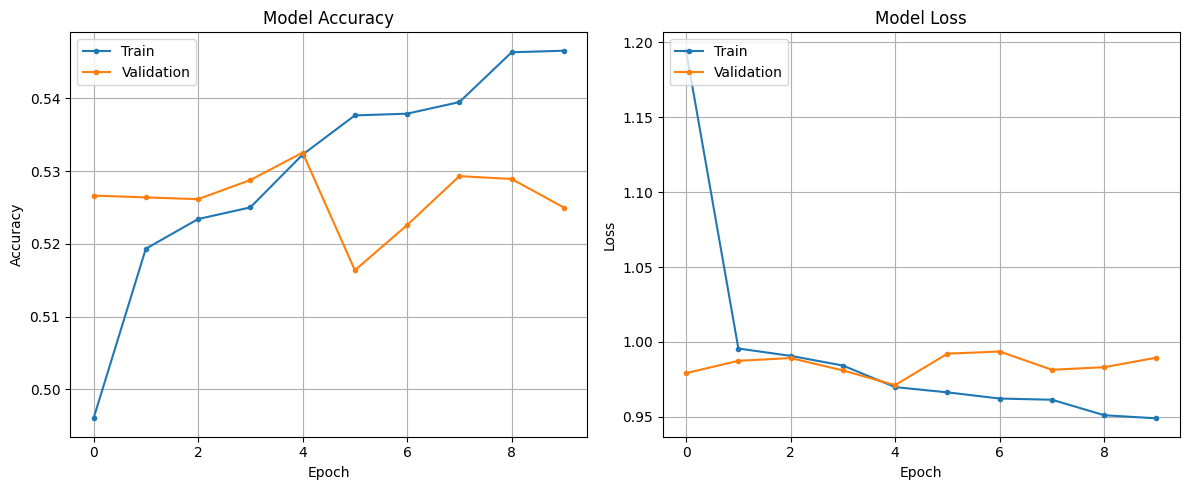

In [140]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker = '.')
plt.plot(history.history['val_accuracy'], marker = '.')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker = '.')
plt.plot(history.history['val_loss'], marker = '.')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('saves/training_history.png')
plt.show()

In [141]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import load_model
from keras.utils import to_categorical

1519/1519 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5309 - loss: 0.9747

Test accuracy: 0.5318
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:
              precision    recall  f1-score   support

         Zbb       0.62      0.89      0.73     11826
         Zcc       0.45      0.53      0.49     11946
         Zss       0.47      0.36      0.41     12773
         Zud       0.57      0.37      0.45     12060

   micro avg       0.53      0.53      0.53     48605
   macro avg       0.53      0.54      0.52     48605
weighted avg       0.53      0.53      0.51     48605
 samples avg       0.53      0.53      0.53     48605



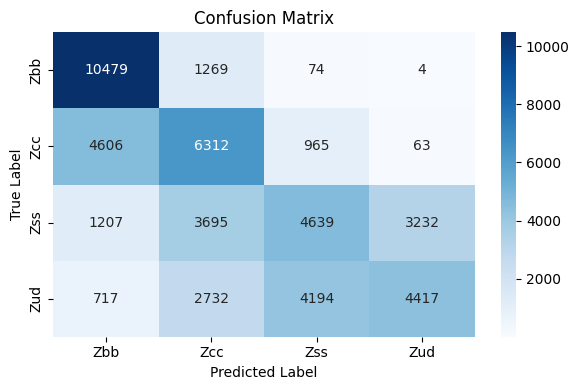

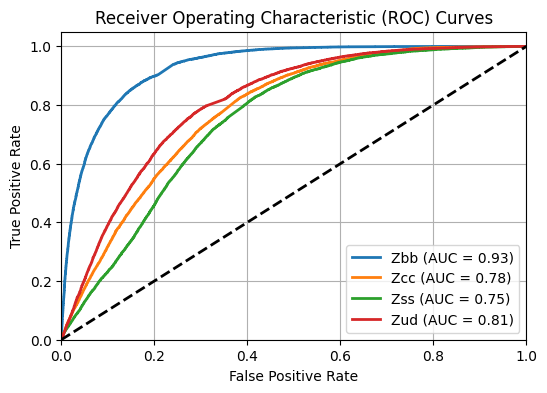

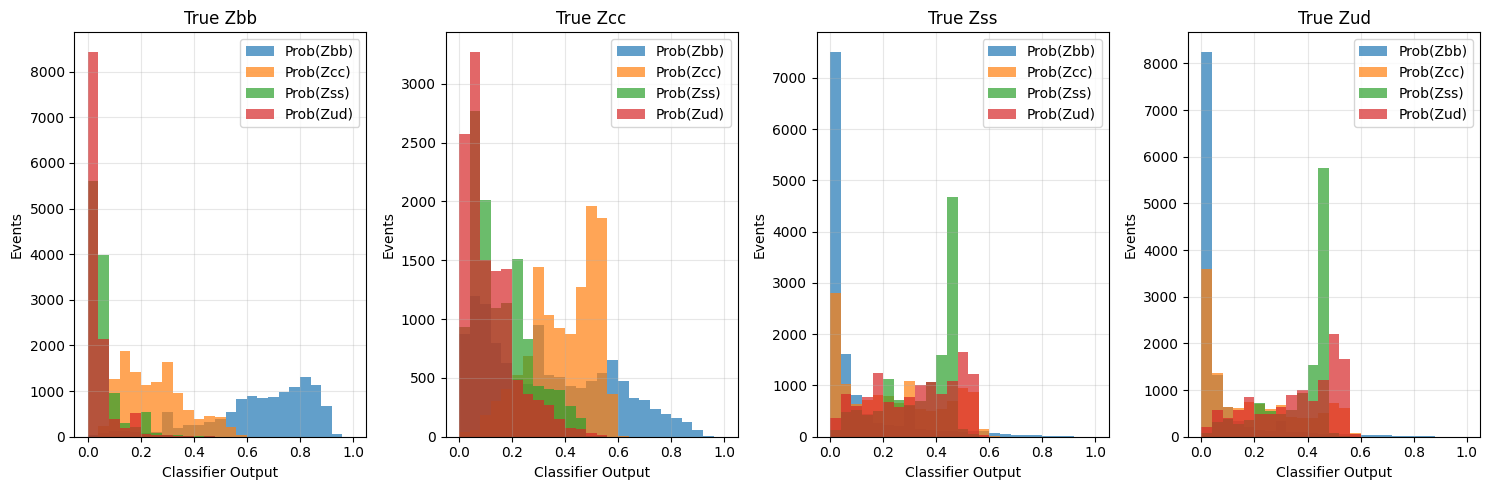

In [168]:

# Assuming that model is already trained, and X_test, y_test are defined

# Evaluate the model on the test set
test_loss, test_acc = dnn_model.evaluate(X_test, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")

# Predict using the dnn_model
y_pred_prob = dnn_model.predict(X_test)  # Model expects one input (X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred_one_hot = to_categorical(y_pred, num_classes=4)
y_test_one_hot = to_categorical(y_test, num_classes=4)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test_one_hot, y_pred_one_hot, target_names=['Zbb', 'Zcc', 'Zss', 'Zud']))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Zbb', 'Zcc', 'Zss', 'Zud'],
            yticklabels=['Zbb', 'Zcc', 'Zss', 'Zud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('saves/confusion_matrix.png')
plt.show()

# Plot ROC curves
plt.figure(figsize=(6, 4))

# One-vs-All ROC curves
for i, flavor in enumerate(['Zbb', 'Zcc', 'Zss', 'Zud']):
    # Convert to one-vs-all problem
    y_test_binary = (y_test == i).astype(int)
    
    # Get ROC curve
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{flavor} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('saves/roc_curves.png')
plt.show()

# Visualize classifier outputs
plt.figure(figsize=(15, 5))

# Create 4 subplots, one for each flavor (Zbb, Zcc, Zss, Zud)
for i, flavor in enumerate(['Zbb', 'Zcc', 'Zss', 'Zud']):
    plt.subplot(1, 4, i+1)
    
    # Get indices of true examples for this flavor
    true_indices = np.where(y_test == i)[0]
    
    # Plot distribution of classifier outputs for this flavor
    for j, pred_flavor in enumerate(['Zbb', 'Zcc', 'Zss', 'Zud']):
        plt.hist(y_pred_prob[true_indices, j], bins=25, alpha=0.7, 
                 label=f'Prob({pred_flavor})', range=(0, 1))
    
    plt.title(f'True {flavor}')
    plt.xlabel('Classifier Output')
    plt.ylabel('Events')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('saves/classifier_outputs.png')
plt.show()

### 2. Sequence Models 

### Seq-Data-Loader

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243023 entries, 0 to 243022
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Thrust_x          243023 non-null  float64
 1   Thrust_y          243023 non-null  float64
 2   Thrust_z          243023 non-null  float64
 3   nParticle         243023 non-null  int32  
 4   nVertex           243023 non-null  int32  
 5   Vertex_chi2       243023 non-null  object 
 6   Vertex_ntracks    243023 non-null  float64
 7   Vertex_chi2_mean  243023 non-null  float64
 8   Vertex_chi2_std   243023 non-null  float64
 9   Particle_p        243023 non-null  object 
 10  Particle_pt       243023 non-null  object 
 11  label             243023 non-null  int64  
 12  Particle_p_mean   243023 non-null  float64
 13  Particle_pt_mean  243023 non-null  float64
dtypes: float64(8), int32(2), int64(1), object(3)
memory usage: 24.1+ MB


In [20]:
target_cols = ['Vertex_chi2', 'Particle_p', 'Particle_pt']

In [21]:
def z_outlier_filter(x, y): ### Only do outlier filtering for non-array objects

    tmp_x = x[:, 0, :10].reshape(len(x), -1)
    z_scores = np.abs(zscore(tmp_x, axis=0))
    mask = z_scores < 4 ##4-th standard deviation
    row_mask = np.all(mask, axis=1)
    
    X_filtered = x[row_mask]
    y_filtered = y[row_mask]

    return X_filtered, y_filtered

In [143]:
def data_prepare(df, target_cols, pad_val=-999):
    """
    Prepares a combined sequence array for RNN input, repeating scalar features across sequence steps
    and padding variable-length sequence features.

    Args:
        df (pd.DataFrame): input dataframe
        target_cols (list): list of sequence feature columns (e.g., ['Particle_p', 'Particle_pt', 'Particle_q'])
        pad_val (float): padding value for shorter sequences

    Returns:
        np.ndarray: shape (n_events, max_seq_len, n_features)
    """
    # Determine max sequence length
    max_seq_len = max([max(len(seq) for seq in df[col]) for col in target_cols])
    print('Max-Sequence-Len:', max_seq_len)

    n_events = len(df)
    
    # Scalar features (non-sequence ones)
    not_target_cols = [col for col in df.columns if col not in target_cols]
    n_scalar_features = len(not_target_cols)
    n_seq_features = len(target_cols)
    n_total_features = n_scalar_features + n_seq_features

    print('Scaler-Features (Event-level): ', n_scalar_features, ', Seq-Features (Particle-Level): ', n_seq_features)

    # Prepare output array
    arr = np.full((n_events, max_seq_len, n_total_features), pad_val, dtype=np.float32)

    for i in range(n_events):
        # Add scalar features (repeated across time)
        scalar_vals = df.iloc[i][not_target_cols].values.astype(np.float32)
        arr[i, :, :n_scalar_features] = np.repeat(scalar_vals[None, :], max_seq_len, axis=0)

        # Add sequence features (with padding if needed)
        for j, col in enumerate(target_cols):
            seq_vals = np.array(df.iloc[i][col], dtype=np.float32)
            arr[i, :len(seq_vals), n_scalar_features + j] = seq_vals

    return arr


df_sub = df[:10000]
label_seq = np.array(df_sub['label'])
seq_array = data_prepare(df_sub.drop(['label'], axis=1), target_cols)

print(seq_array.shape, label_seq.shape)  # (1000, max_seq_len, 3)

Max-Sequence-Len: 107
Scaler-Features (Event-level):  10 , Seq-Features (Particle-Level):  3
(10000, 107, 13) (10000,)


In [144]:
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    seq_array, label_seq, test_size=0.15, random_state=42, stratify=label_seq
)

X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
    X_train_seq, y_train_seq, test_size=0.25, random_state=42, stratify=y_train_seq
)

print(X_train_seq.shape, X_val_seq.shape, X_test_seq.shape)

(6375, 107, 13) (2125, 107, 13) (1500, 107, 13)


In [145]:
X_filtered_seq, y_filtered_seq = z_outlier_filter(X_train_seq, y_train_seq)
print(X_filtered_seq.shape, y_filtered_seq.shape)

(6257, 107, 13) (6257,)


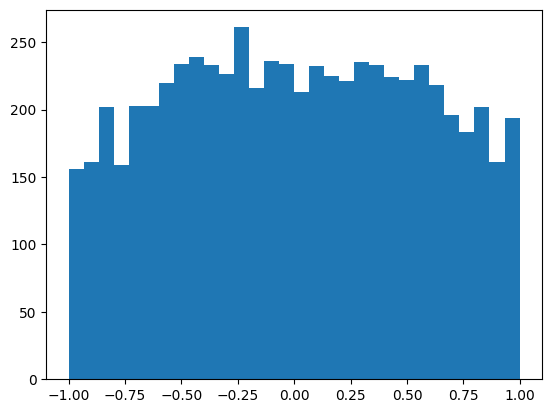

0.023024948


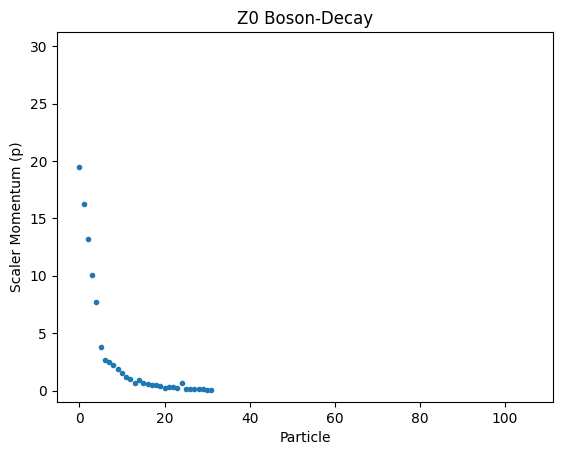

In [146]:
### First n_scalers are scaler(repeated) features 
plt.hist(X_train_seq[:, 0, 0], bins=30)
plt.show()

rn_event = random.randint(0, len(X_train_seq) - 1)

## For seq/sets (-2) is the decay-Particle scaler momentum
second_min = sorted(set(X_train_seq[rn_event, :, -2]), reverse=False)[1]
first_max = max(X_train_seq[rn_event, :, -2])
print(second_min)

plt.scatter(np.arange(len(X_train_seq[0, :, -2])), X_train_seq[0, :, -2], marker='.')
plt.ylim(second_min - 1, first_max)
plt.ylabel('Scaler Momentum (p)')
plt.xlabel('Particle')
plt.title('Z0 Boson-Decay')
plt.show()

### Save Data (Preprocessed)

In [147]:
print(X_filtered_seq.shape, X_val_seq.shape, X_test_seq.shape, y_filtered_seq.shape, y_val_seq.shape, y_test_seq.shape)

(6257, 107, 13) (2125, 107, 13) (1500, 107, 13) (6257,) (2125,) (1500,)


In [148]:
np.savez('data/preprocessed/data_seq.npz', 
         x_train=X_filtered_seq, x_val=X_val_seq, x_test=X_test_seq, 
         y_train=y_filtered_seq, y_val=y_val_seq, y_test=y_test_seq)

### Load Data (Preprocessed)

In [381]:
loaded_data = np.load('data/preprocessed/data_seq.npz')

X_filtered_seq = loaded_data['x_train']
X_val_seq = loaded_data['x_val']
X_test_seq = loaded_data['x_test']
y_filtered_seq = loaded_data['y_train']
y_val_seq = loaded_data['y_val']
y_test_seq = loaded_data['y_test']

In [149]:
print(X_filtered_seq.shape, X_val_seq.shape, X_test_seq.shape, y_filtered_seq.shape, y_val_seq.shape, y_test_seq.shape)

(6257, 107, 13) (2125, 107, 13) (1500, 107, 13) (6257,) (2125,) (1500,)


In [150]:
normalizer = Normalization(axis=-1) ## feature-wise Normalization (like StandardScaler())  
normalizer.adapt(X_filtered_seq) 

#### RNNs (GRU) -- Permutation Variant

In [151]:
import utils.model
import utils.train

importlib.reload(utils.model)
importlib.reload(utils.train)

from utils.model import *
from utils.train import *

In [152]:
# gru_model = gru_classifier_v1(input_shape=X_filtered_seq.shape[1:], normalizer=normalizer)
gru_model = gru_classifier_v2(input_shape=X_filtered_seq.shape[1:], normalizer=normalizer)
gru_model.summary()

c:\Users\Alik\Desktop\M_year\MPhil\Lent\A3\am3353\a3-env-2\Lib\site-packages\keras\src\layers\layer.py:939: UserWarning: Layer 'flatten_4' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 107, 13)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_31    │ (None, 107, 13)   │         27 │ input_layer_28[0… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_20        │ (None, 107, 13)   │          0 │ normalization_31… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_20          │ (None, 107, 13)   │          0 │ normalization_31… │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_20 (Any)        │ (None, 107)       │          0 │ not_equal_20[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_23    │ (None, 107, 250)  │    105,000 │ masking_20[0][0], │
│ (Bidirectional)     │                   │            │ any_20[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 107, 250)  │      1,000 │ bidirectional_23… │
│ (BatchNormalizatio… │                   │            │ any_20[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_83          │ (None, 107, 250)  │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_24    │ (None, 107, 250)  │    282,750 │ dropout_83[0][0], │
│ (Bidirectional)     │                   │            │ any_20[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 107, 250)  │          0 │ bidirectional_24… │
│                     │                   │            │ bidirectional_23… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logical_or_4        │ (None, 107)       │          0 │ any_20[0][0],     │
│ (LogicalOr)         │                   │            │ any_20[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 107, 250)  │      1,000 │ add_4[0][0],      │
│ (BatchNormalizatio… │                   │            │ logical_or_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_131 (Dense)   │ (None, 107, 1)    │        251 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 107)       │          0 │ dense_131[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 107)       │          0 │ flatten_4[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_4     │ (None, 250, 107)  │          0 │ activation_4[0][… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_4 (Permute) │ (None, 107, 250)  │          0 │ repeat_vector_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 107, 250)  │          0 │ batch_normalizat… │
│ (Multiply)          │                   │            │ permute_4[0][0] 

 Total params: 422,407 (1.61 MB)

 Trainable params: 421,130 (1.61 MB)

 Non-trainable params: 1,277 (4.99 KB)

In [153]:
ft = time.time()
history_rnn, gru_model = train_gru([X_filtered_seq, y_filtered_seq], [X_val_seq, y_val_seq], epochs=50)
lt = time.time()

print('time taken (train): ', (lt - ft) / 60, ' mins')

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 69s 280ms/step - accuracy: 0.4863 - loss: 1.0713 - val_accuracy: 0.5294 - val_loss: 0.9675 - learning_rate: 0.0010
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 43s 221ms/step - accuracy: 0.5219 - loss: 0.9695 - val_accuracy: 0.5336 - val_loss: 0.9593 - learning_rate: 0.0010
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 38s 194ms/step - accuracy: 0.5280 - loss: 0.9465 - val_accuracy: 0.5369 - val_loss: 0.9477 - learning_rate: 0.0010
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 210ms/step - accuracy: 0.5431 - loss: 0.9354 - val_accuracy: 0.5468 - val_loss: 0.9417 - learning_rate: 0.0010
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 205ms/step - accuracy: 0.5524 - loss: 0.9305 - val_accuracy: 0.5506 - val_loss: 0.9369 - learning_rate: 0.0010
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - accuracy: 0.5493 - loss: 0.9230 - val_accuracy: 0.5652 - val_loss: 0.9342 - learning_rate: 0.0010
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 39s 197ms/step - accuracy: 0.5

time taken (train):  17.112452268600464  mins


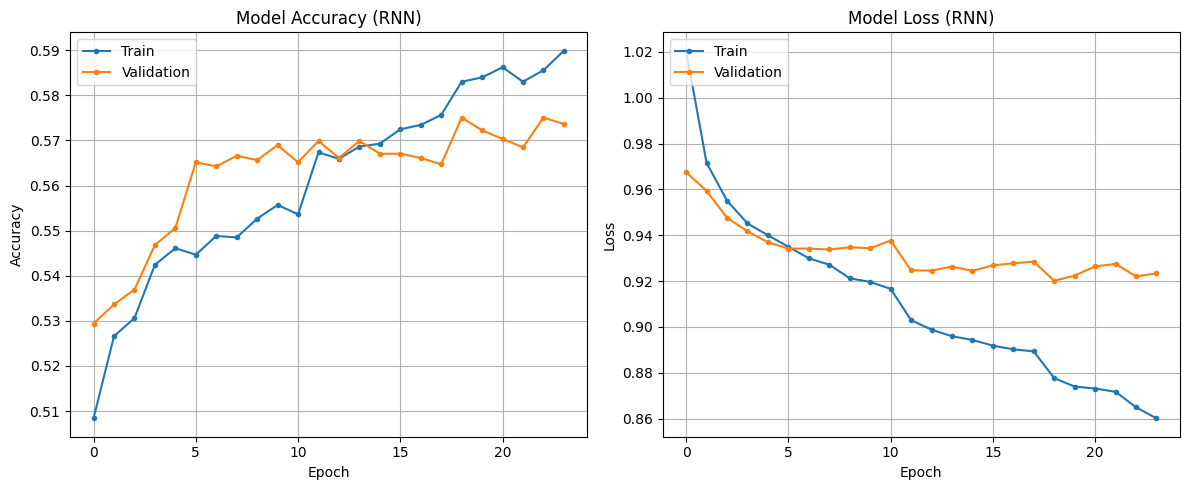

In [154]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['accuracy'], marker = '.')
plt.plot(history_rnn.history['val_accuracy'], marker = '.')
plt.title('Model Accuracy (RNN)')
plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['loss'], marker = '.')
plt.plot(history_rnn.history['val_loss'], marker = '.')
plt.title('Model Loss (RNN)')
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('saves/training_history.png')
plt.show()

### Metrics

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.5874 - loss: 0.8882

Test accuracy: 0.5680
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step
<class 'numpy.ndarray'> (1500, 4)

Classification Report:
              precision    recall  f1-score   support

         Zbb       0.73      0.82      0.77       364
         Zcc       0.49      0.59      0.54       361
         Zss       0.49      0.25      0.33       393
         Zud       0.52      0.63      0.57       382

   micro avg       0.57      0.57      0.57      1500
   macro avg       0.56      0.57      0.55      1500
weighted avg       0.56      0.57      0.55      1500
 samples avg       0.57      0.57      0.57      1500



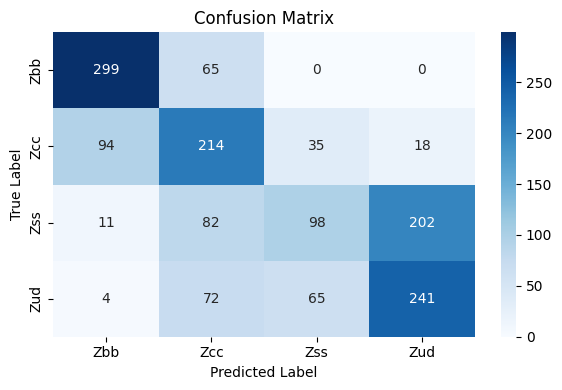

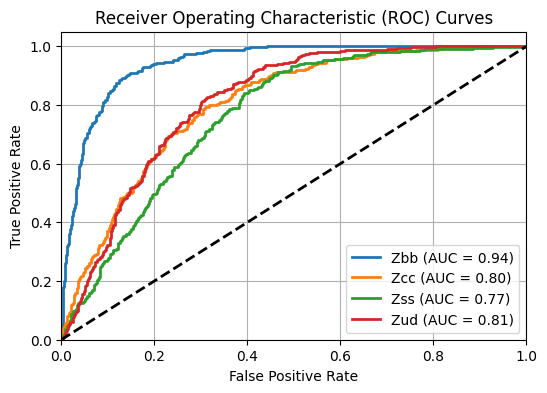

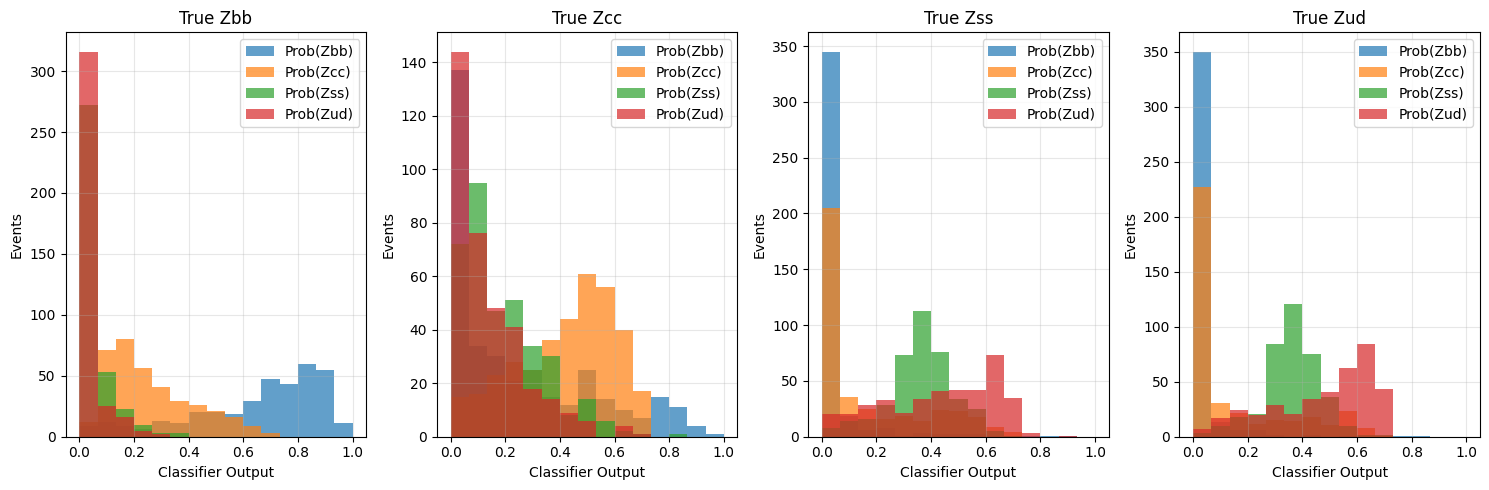

In [191]:

# Evaluate the model on the test set
test_loss, test_acc = gru_model.evaluate(X_test_seq, y_test_seq)
print(f"\nTest accuracy: {test_acc:.4f}")

# Predict using the dnn_model
y_pred_prob = gru_model.predict(X_test_seq)  # Model expects one input (X_test)
y_pred_prob = tf.nn.softmax(y_pred_prob, axis=-1).numpy()
print(type(y_pred_prob), y_pred_prob.shape)
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred_one_hot = to_categorical(y_pred, num_classes=4)
y_test_one_hot = to_categorical(y_test_seq, num_classes=4)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test_one_hot, y_pred_one_hot, target_names=['Zbb', 'Zcc', 'Zss', 'Zud']))

# Create confusion matrix
cm = confusion_matrix(y_test_seq, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Zbb', 'Zcc', 'Zss', 'Zud'],
            yticklabels=['Zbb', 'Zcc', 'Zss', 'Zud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('saves/confusion_matrix.png')
plt.show()

# Plot ROC curves
plt.figure(figsize=(6, 4))

# One-vs-All ROC curves
for i, flavor in enumerate(['Zbb', 'Zcc', 'Zss', 'Zud']):
    # Convert to one-vs-all problem
    y_test_binary = (y_test_seq == i).astype(int)
    
    # Get ROC curve
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{flavor} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('saves/roc_curves.png')
plt.show()

# Visualize classifier outputs
plt.figure(figsize=(15, 5))

# Create 4 subplots, one for each flavor (Zbb, Zcc, Zss, Zud)
for i, flavor in enumerate(['Zbb', 'Zcc', 'Zss', 'Zud']):
    plt.subplot(1, 4, i+1)
    
    # Get indices of true examples for this flavor
    true_indices = np.where(y_test_seq == i)[0]
    
    # Plot distribution of classifier outputs for this flavor
    for j, pred_flavor in enumerate(['Zbb', 'Zcc', 'Zss', 'Zud']):
        plt.hist(y_pred_prob[true_indices, j], bins=15, alpha=0.7, 
                 label=f'Prob({pred_flavor})', range=(0, 1))
    
    plt.title(f'True {flavor}')
    plt.xlabel('Classifier Output')
    plt.ylabel('Events')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('saves/classifier_outputs.png')
plt.show()

### DeepSets - Permutation Invariance

### Fundamental Theorem Behind DeepSets

Let $X = \{x_1, x_2, \dots, x_n\}$, where each $x_i \in \mathbb{R}^d$. A function $f(X)$ is **permutation invariant** if:

$$
f(x_1, x_2, \dots, x_n) = f(x_{\pi(1)}, x_{\pi(2)}, \dots, x_{\pi(n)})
$$

for any permutation $\pi$ of the indices $\{1, 2, \dots, n\}$.

**Theorem (Zaheer et al., 2017):**  
Any permutation-invariant function $f$ operating on a set $X$ can be universally approximated by a function of the form:

$$
f(X) = \rho \left( \sum_{x \in X} \phi(x) \right)
$$

for suitable transformations $\phi: \mathbb{R}^d \to \mathbb{R}^k$ and $\rho: \mathbb{R}^k \to \mathbb{R}$, both of which can be parameterized by neural networks.

---

### Components of the Architecture

- **Element-wise transformation $\phi(x)$**:  
  A shared function (e.g., a multilayer perceptron) applied independently to each element $x \in X$, mapping it to a latent representation.

- **Aggregation $\sum_{x \in X} \phi(x)$**:  
  A permutation-invariant operation used to combine the individual representations into a fixed-size vector. Common choices include summation, averaging, or maximization.

- **Output transformation $\rho$**:  
  A function that maps the aggregated representation to the final output. This may correspond to a classification, regression, or other task-specific prediction.


In [203]:
import utils.model
import utils.train

importlib.reload(utils.model)
importlib.reload(utils.train)

from utils.model import *
from utils.train import *

In [196]:
normalizer = Normalization(axis=-1) ## feature-wise Normalization (like StandardScaler())  
normalizer.adapt(X_filtered_seq) 

In [199]:
# deepset_model = deepset_classifier_v1(input_shape=X_filtered_seq.shape[1:], normalizer=normalizer)
deepset_model = deepset_classifier_v2(input_shape=X_filtered_seq.shape[1:], normalizer=normalizer)
deepset_model.summary()

c:\Users\Alik\Desktop\M_year\MPhil\Lent\A3\am3353\a3-env-2\Lib\site-packages\keras\src\layers\layer.py:939: UserWarning: Layer 'lambda_19' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\Alik\Desktop\M_year\MPhil\Lent\A3\am3353\a3-env-2\Lib\site-packages\keras\src\layers\layer.py:939: UserWarning: Layer 'global_max_pooling1d_6' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_62"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_48      │ (None, 107, 13)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_39    │ (None, 107, 13)   │         27 │ input_layer_48[0… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_31        │ (None, 107, 13)   │          0 │ normalization_39… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_31          │ (None, 107, 13)   │          0 │ normalization_39… │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_31 (Any)        │ (None, 107)       │          0 │ not_equal_31[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_17 │ (None, 107, 256)  │    535,296 │ masking_31[0][0], │
│ (TimeDistributed)   │                   │            │ any_31[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_19 (Lambda)  │ (None, 256)       │          0 │ time_distributed… │
│                     │                   │            │ any_31[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ time_distributed… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 512)       │          0 │ lambda_19[0][0],  │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_182 (Dense)   │ (None, 128)       │     65,664 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_182[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_104         │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_183 (Dense)   │ (None, 64)        │      8,256 │ dropout_104[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_183[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_105         │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_184 (Dense)   │ (None, 4)         │        260 │ dropout_105[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 610,271 (2.33 MB)

 Trainable params: 606,788 (2.31 MB)

 Non-trainable params: 3,483 (13.61 KB)

In [204]:
history_deepset, deepset_model = train_deepset([X_filtered_seq, y_filtered_seq], [X_val_seq, y_val_seq], epochs=50)

c:\Users\Alik\Desktop\M_year\MPhil\Lent\A3\am3353\a3-env-2\Lib\site-packages\keras\src\layers\layer.py:939: UserWarning: Layer 'lambda_21' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\Alik\Desktop\M_year\MPhil\Lent\A3\am3353\a3-env-2\Lib\site-packages\keras\src\layers\layer.py:939: UserWarning: Layer 'global_max_pooling1d_7' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/50


KeyboardInterrupt: 

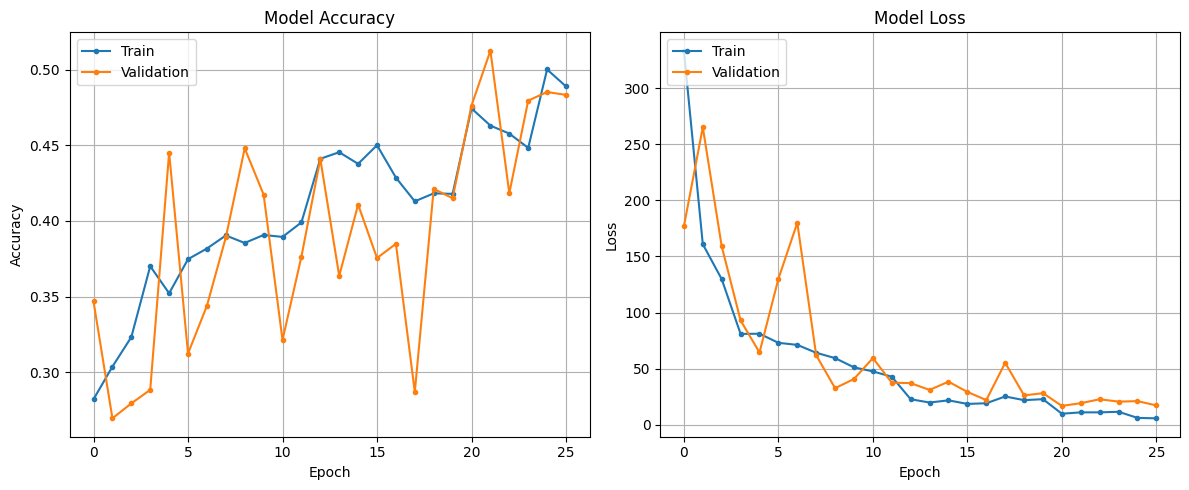

In [201]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_deepset.history['accuracy'], marker = '.')
plt.plot(history_deepset.history['val_accuracy'], marker = '.')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_deepset.history['loss'], marker = '.')
plt.plot(history_deepset.history['val_loss'], marker = '.')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('saves/training_history.png')
plt.show()

### Metrics

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4775 - loss: 31.5565

Test accuracy: 0.4640
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step

Classification Report:
              precision    recall  f1-score   support

         Zbb       0.55      0.88      0.68       364
         Zcc       0.31      0.43      0.36       361
         Zss       0.46      0.08      0.13       393
         Zud       0.53      0.49      0.51       382

   micro avg       0.46      0.46      0.46      1500
   macro avg       0.46      0.47      0.42      1500
weighted avg       0.46      0.46      0.42      1500
 samples avg       0.46      0.46      0.46      1500



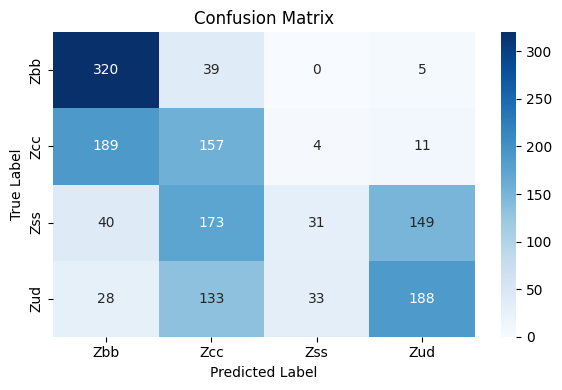

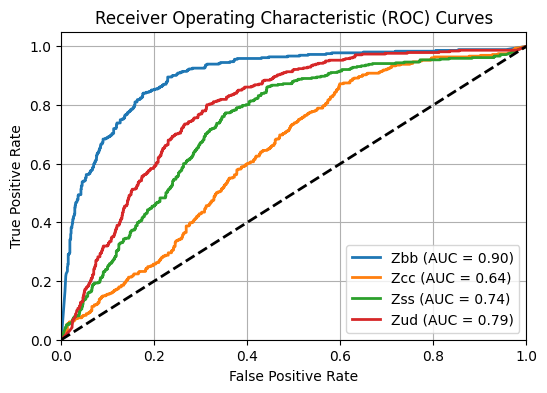

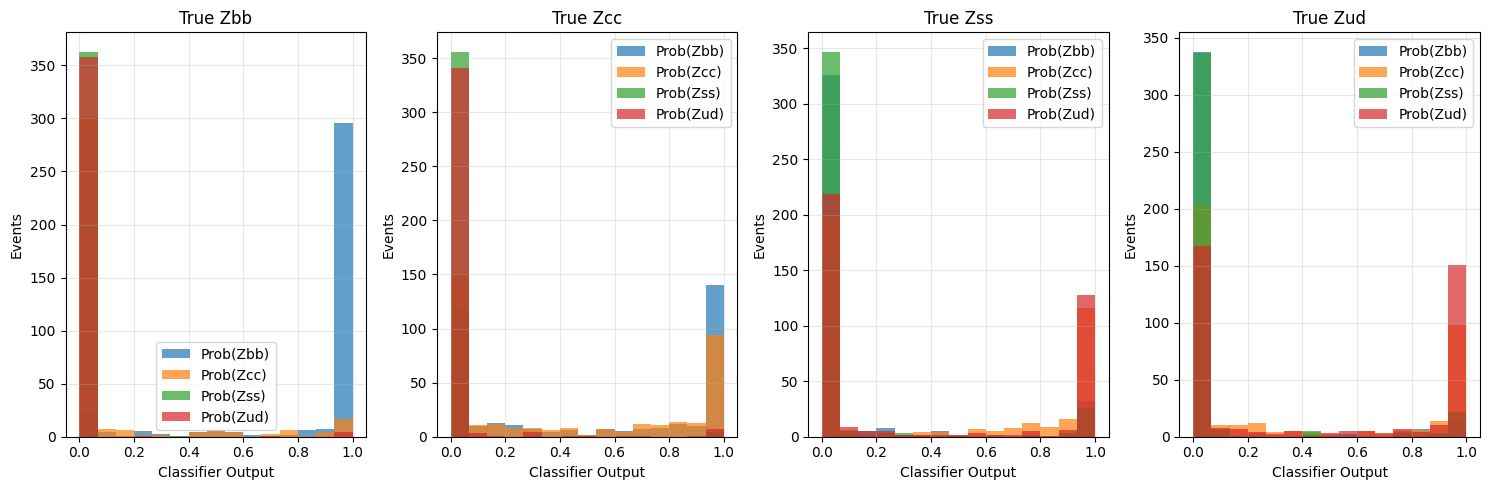

In [202]:
# Evaluate the model on the test set
test_loss, test_acc = deepset_model.evaluate(X_test_seq, y_test_seq)
print(f"\nTest accuracy: {test_acc:.4f}")

# Predict using the dnn_model
y_pred_prob = deepset_model.predict(X_test_seq)  # Model expects one input (X_test)
y_pred_prob = tf.nn.softmax(y_pred_prob, axis=-1).numpy()
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred_one_hot = to_categorical(y_pred, num_classes=4)
y_test_one_hot = to_categorical(y_test_seq, num_classes=4)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test_one_hot, y_pred_one_hot, target_names=['Zbb', 'Zcc', 'Zss', 'Zud']))

# Create confusion matrix
cm = confusion_matrix(y_test_seq, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Zbb', 'Zcc', 'Zss', 'Zud'],
            yticklabels=['Zbb', 'Zcc', 'Zss', 'Zud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('saves/confusion_matrix.png')
plt.show()

# Plot ROC curves
plt.figure(figsize=(6, 4))

# One-vs-All ROC curves
for i, flavor in enumerate(['Zbb', 'Zcc', 'Zss', 'Zud']):
    # Convert to one-vs-all problem
    y_test_binary = (y_test_seq == i).astype(int)
    
    # Get ROC curve
    fpr, tpr, _ = roc_curve(y_test_binary, y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{flavor} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('saves/roc_curves.png')
plt.show()

# Visualize classifier outputs
plt.figure(figsize=(15, 5))

# Create 4 subplots, one for each flavor (Zbb, Zcc, Zss, Zud)
for i, flavor in enumerate(['Zbb', 'Zcc', 'Zss', 'Zud']):
    plt.subplot(1, 4, i+1)
    
    # Get indices of true examples for this flavor
    true_indices = np.where(y_test_seq == i)[0]
    # Plot distribution of classifier outputs for this flavor
    for j, pred_flavor in enumerate(['Zbb', 'Zcc', 'Zss', 'Zud']):
        plt.hist(y_pred_prob[true_indices, j], bins=15, alpha=0.7, 
                 label=f'Prob({pred_flavor})', range=(0, 1))
    
    plt.title(f'True {flavor}')
    plt.xlabel('Classifier Output')
    plt.ylabel('Events')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('saves/classifier_outputs.png')
plt.show()